# BUSI/COMP 488-003 Assignment 1

## Peer2Peer Lending with lendingclub.com

Group 5: Avi Agrawal, Reed Dickerson, Izzy Parrett, Shivram Ramkumar, Nora Xia, Natalie Yuziuk

## Question

- How do we get Dr. D a competitive advantage when he invests in lendingclub.com?

### Scenario
Peer to peer lending focuses on investors being able to directly contribute a portion of the principal on loans to individuals. Lendingclub lets these investors back loans from \\$1,000 to \\$40,000. 

Investors make money by getting their contribution paid back with varying levels of interest. The loans are rated at different grades from A1 to G5, with A1 being the best. 

### Assumptions
Dr. D needs to earn the greatest possible profit. This relies on getting the largest gains in interest rates while simultaneously minimizing the risk of loan default, which should be prioritized. Defaults may wipe out a significant ratio of the gains from the interest rates. So how do we minimize the risk of default?

We assume that the accepted loans file is in the same folder/directory as the notebook. 

## Visualize the data - exploration and data cleaning

***Import necessary libraries***

In [1]:
import numpy as np
import pandas as pd
import pickle
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve
%matplotlib inline

# Support functions for much later modeling
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scoring Functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# create a Pandas Dataframe called accepted
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv')

# rejected = pd.read_csv('rejected_2007_to_2018Q4.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(accepted.describe())

       member_id     loan_amnt   funded_amnt  funded_amnt_inv      int_rate  \
count        0.0  2.260668e+06  2.260668e+06     2.260668e+06  2.260668e+06   
mean         NaN  1.504693e+04  1.504166e+04     1.502344e+04  1.309283e+01   
std          NaN  9.190245e+03  9.188413e+03     9.192332e+03  4.832138e+00   
min          NaN  5.000000e+02  5.000000e+02     0.000000e+00  5.310000e+00   
25%          NaN  8.000000e+03  8.000000e+03     8.000000e+03  9.490000e+00   
50%          NaN  1.290000e+04  1.287500e+04     1.280000e+04  1.262000e+01   
75%          NaN  2.000000e+04  2.000000e+04     2.000000e+04  1.599000e+01   
max          NaN  4.000000e+04  4.000000e+04     4.000000e+04  3.099000e+01   

        installment    annual_inc           dti   delinq_2yrs  fico_range_low  \
count  2.260668e+06  2.260664e+06  2.258957e+06  2.260639e+06    2.260668e+06   
mean   4.458068e+02  7.799243e+04  1.882420e+01  3.068792e-01    6.985882e+02   
std    2.671735e+02  1.126962e+05  1.418333e+

### Data Columns/Categories
Below is the list of 151 columns within the uncleaned dataset.

In [4]:
print(accepted.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 151 columns):
 #    Column                                      Non-Null Count    Dtype  
---   ------                                      --------------    -----  
 0    id                                          2260701 non-null  object 
 1    member_id                                   0 non-null        float64
 2    loan_amnt                                   2260668 non-null  float64
 3    funded_amnt                                 2260668 non-null  float64
 4    funded_amnt_inv                             2260668 non-null  float64
 5    term                                        2260668 non-null  object 
 6    int_rate                                    2260668 non-null  float64
 7    installment                                 2260668 non-null  float64
 8    grade                                       2260668 non-null  object 
 9    sub_grade                                   

### Loan Status
Below, the loan statuses and the number of each loan are displayed. 

From this, we determined that **Fully Paid** and **Charged Off** were the two catergories to single out in order to create predictive models with decisive results.

In [5]:
# visualize the different categories of the target variable
print(accepted['loan_status'].value_counts())

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64


In [6]:
# focus the prediction model on fully paid and charged off, since current loans are still in progress
df = accepted[(accepted['loan_status'] == 'Fully Paid') | (accepted['loan_status'] == 'Charged Off')]

In [7]:
# check the shape of the dataframe
print(df.shape)

# verify that only two target values remain
print(df['loan_status'].value_counts())

(1345310, 151)
Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64


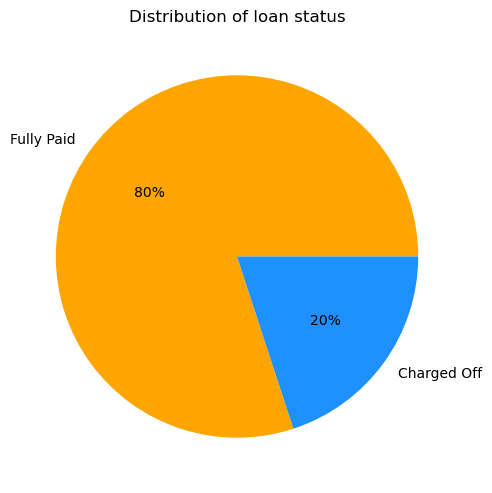

In [8]:
# visualize the Fully Paid vs. Charged Off
figure(figsize=(8, 6), dpi=100)
plt.pie(df['loan_status'].value_counts(), 
        labels=['Fully Paid', 'Charged Off'], 
        autopct='%.0f%%',
        colors = ["orange", "dodgerblue"])
plt.title('Distribution of loan status')
plt.show()

### Pre-Cleaned Data Loan Status Distribution

Above is the distribution of the Loan Status, only taking into account the loans that have been fully paid and loans that have been charged off.

As said previously, other loan statuses were ignored because they were deemed unnecessary variables for predictive modeling.

### Data Cleaning

Below, fully paid loans and charged off loans will be converted to 1 and 0 respectively, and features that are contain over 30% null values will be removed in order to facilitate the handling of the data.

In [9]:
# replace the loan status categorical columns with numbers
# Fully Paid: 1
# Charged Off: 0
df_num = df.copy()
df_num.loc[:, 'loan_status'].replace({'Fully Paid': 1, 'Charged Off': 0}, inplace=True)
#print(df_num['loan_status'].unique())

In [10]:
# begin removing null values
null = df_num.isnull().mean()

In [110]:
# select the features for which more than 30% are null
null = null[null > 0.3]
#print(null.shape)

In [12]:
# isolate the columns
null_col = null.index
null_col

Index(['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record',
       'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount'

In [13]:
# drop those columns from df_num
df_null_rem = df_num.drop(null_col, axis = 1)
df_null_rem.shape

(1345310, 93)

In [14]:
# now drop the records for which there exist null values
df_null_rem = df_null_rem.dropna(axis = 0).reset_index(drop = True)
df_null_rem.shape

(986013, 93)

In [15]:
df_null_rem.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986013 entries, 0 to 986012
Data columns (total 93 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          986013 non-null  object 
 1   loan_amnt                   986013 non-null  float64
 2   funded_amnt                 986013 non-null  float64
 3   funded_amnt_inv             986013 non-null  float64
 4   term                        986013 non-null  object 
 5   int_rate                    986013 non-null  float64
 6   installment                 986013 non-null  float64
 7   grade                       986013 non-null  object 
 8   sub_grade                   986013 non-null  object 
 9   emp_title                   986013 non-null  object 
 10  emp_length                  986013 non-null  object 
 11  home_ownership              986013 non-null  object 
 12  annual_inc                  986013 non-null  float64
 13  verification_s

### Cleaned Categories
As seen above, there are now only 93 categories left after removing those that contained over 30% null values.

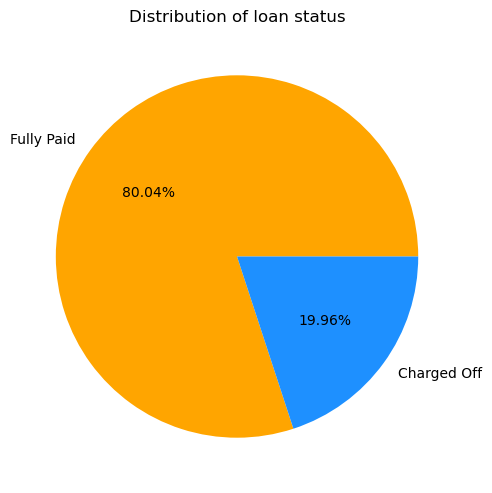

In [16]:
# visualize the Fully Paid vs. Charged Off
figure(figsize=(8, 6), dpi=100)
plt.pie(df['loan_status'].value_counts(), 
        labels=['Fully Paid', 'Charged Off'], 
        autopct='%.02f%%',
        colors = ["orange", "dodgerblue"])
plt.title('Distribution of loan status')
plt.show()

## Visualization
We have the data cleaned above, with 986,013 total records, and a split of around 80% of the loans being fully paid and 20% charged off. We now begin to visualize individual categories and the potential impact we believe they might have on the outcome of the loan.

Some of these variables include
- loan amount
- interest rate
- term
- (sub)grade
- home_ownership
- purpose
- dti

****Note that loan_status 0 is charged off, and loan_status 1 is fully paid*

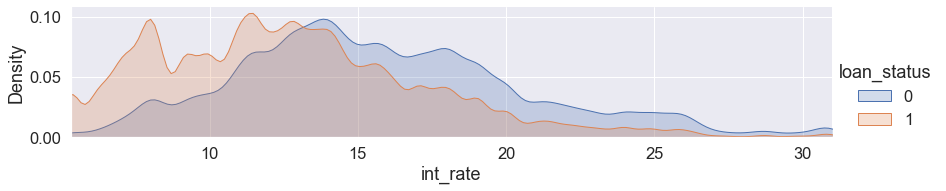

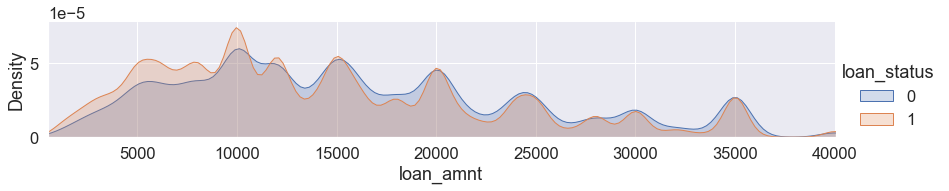

In [17]:
# visualize the distributions of numerical variables by loan status
sns.set(font_scale = 1.5)
# in particular, visualize interest rate and loan amount here
for col in ['int_rate', 'loan_amnt']:
    facet = sns.FacetGrid(df_null_rem, hue='loan_status',aspect=4)
    facet.map(sns.kdeplot, col, shade= True)
    facet.set(xlim=(df[col].min(), df[col].max()))
    facet.add_legend()
    plt.show()

<AxesSubplot:xlabel='loan_status', ylabel='int_rate'>

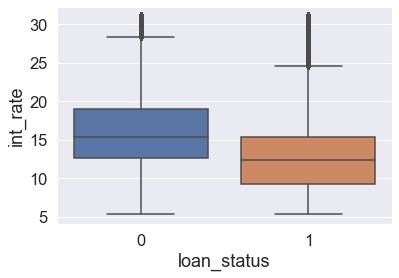

In [18]:
# create a boxplot of interest rate, split by loan_status
sns.boxplot(data = df_null_rem, y='int_rate', x='loan_status')


<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

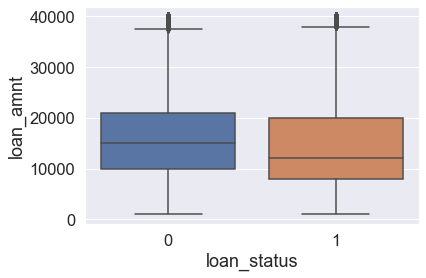

In [19]:
# create a boxplot of loan amount, split by loan status
sns.boxplot(data = df_null_rem, y='loan_amnt', x='loan_status')

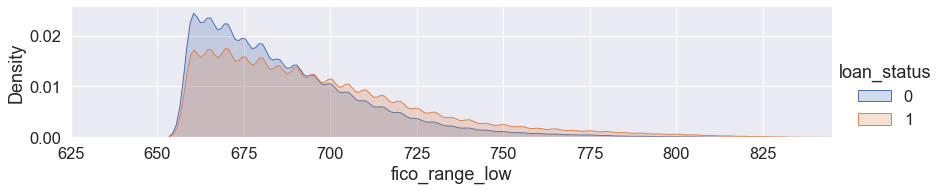

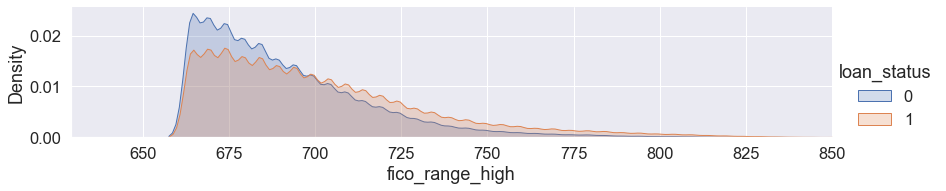

In [20]:
# see how the low and high ranges of the FICO scores deviate by loan status
sns.set(font_scale = 1.5)
for col in ['fico_range_low', 'fico_range_high']:
    facet = sns.FacetGrid(df_null_rem, hue='loan_status',aspect=4)
    facet.map(sns.kdeplot, col, shade= True)
    facet.set(xlim=(df[col].min(), df[col].max()))
    facet.add_legend()
    plt.show()

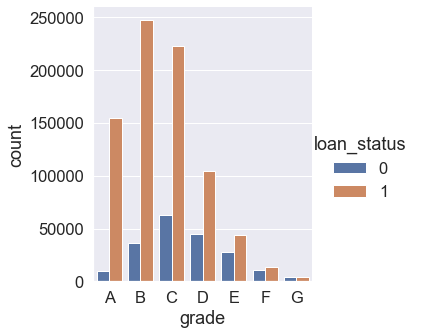

In [21]:
# visualize a categorical plot breakup of loan status by grade
sns.catplot(data=df_null_rem, x='grade', hue='loan_status', kind='count', order=['A','B','C','D','E','F','G'])

<AxesSubplot:xlabel='last_fico_range_high', ylabel='Count'>

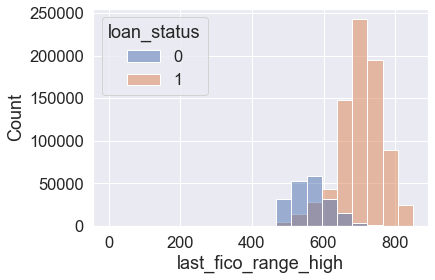

In [22]:
# get a histogram of the last_fico_range_high
sns.histplot(data=df_null_rem,
             x='last_fico_range_high',
             hue='loan_status',
             bins=20)

<AxesSubplot:xlabel='last_fico_range_low', ylabel='Count'>

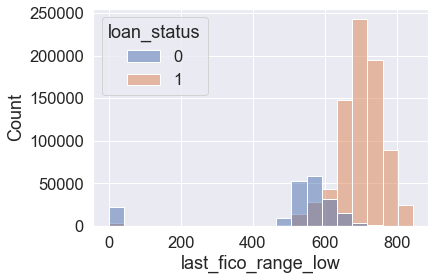

In [23]:
# histogram of last_fico_range_low
sns.histplot(data=df_null_rem,
             x='last_fico_range_low',
             hue='loan_status',
             bins=20)

<AxesSubplot:xlabel='loan_status', ylabel='last_fico_range_high'>

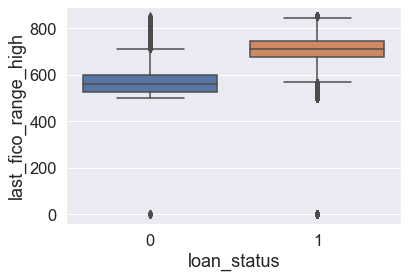

In [24]:
# box plot of last_fico_range_high
sns.boxplot(data = df_null_rem, y='last_fico_range_high', x='loan_status')

### Why are these variables so distinct? 
**They may be influenced by the outcome (charged off loan or fully paid loan), so we cannot properly predict using the last_fico_ranges as a feature.**

<AxesSubplot:xlabel='loan_status', ylabel='fico_range_low'>

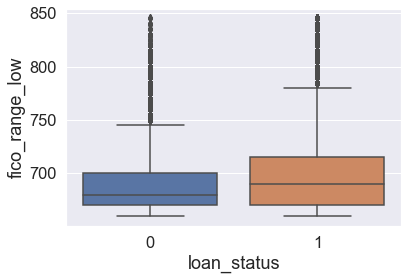

In [25]:
# view the distribution of fico_range_low
sns.boxplot(data = df_null_rem, y='fico_range_low', x='loan_status')

In [26]:
# create a mapping function to make use of emp_length
df_null_rem['emp_length'].unique()
emp_length_map = {'< 1 year': 0, 
                  '1 year': 1, 
                  '2 years': 2, 
                  '3 years': 3, 
                  '4 years': 4, 
                  '5 years': 5, 
                  '6 years': 6, 
                  '7 years': 7, 
                  '8 years': 8, 
                  '9 years': 9, 
                  '10+ years': 10}

In [27]:
# apply the emp_length mapping function
df_null_rem.loc[:, 'emp_length'].replace(emp_length_map, inplace=True)
df_null_rem['emp_length'].unique()

array([10,  3,  6,  7,  8,  2,  5,  9,  0,  1,  4], dtype=int64)

<AxesSubplot:xlabel='annual_inc', ylabel='Count'>

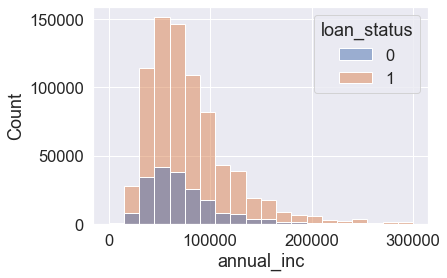

In [28]:
sns.histplot(data=df_null_rem, x='annual_inc', hue='loan_status', binrange=[0, 300000], bins=20)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, 'PA'),
  Text(1, 0, 'SD'),
  Text(2, 0, 'MN'),
  Text(3, 0, 'SC'),
  Text(4, 0, 'RI'),
  Text(5, 0, 'CA'),
  Text(6, 0, 'VA'),
  Text(7, 0, 'AZ'),
  Text(8, 0, 'MD'),
  Text(9, 0, 'NY'),
  Text(10, 0, 'TX'),
  Text(11, 0, 'KS'),
  Text(12, 0, 'NM'),
  Text(13, 0, 'AL'),
  Text(14, 0, 'WA'),
  Text(15, 0, 'OH'),
  Text(16, 0, 'GA'),
  Text(17, 0, 'IL'),
  Text(18, 0, 'FL'),
  Text(19, 0, 'CO'),
  Text(20, 0, 'IN'),
  Text(21, 0, 'MI'),
  Text(22, 0, 'MO'),
  Text(23, 0, 'DC'),
  Text(24, 0, 'MA'),
  Text(25, 0, 'WI'),
  Text(26, 0, 'NJ'),
  Text(27, 0, 'DE'),
  Text(28, 0, 'TN'),
  Text(29, 0, 'NH'),
  Text(30, 0, 'NE'),
  Text(31, 0, 'OR'),
  Text(32, 0, 'NC'),
  Text(33, 0, 'AR'),
  Text(34, 0, 'NV'),
  Text(35, 0, 'WV'),
  Text(36, 0, 'LA'),
  T

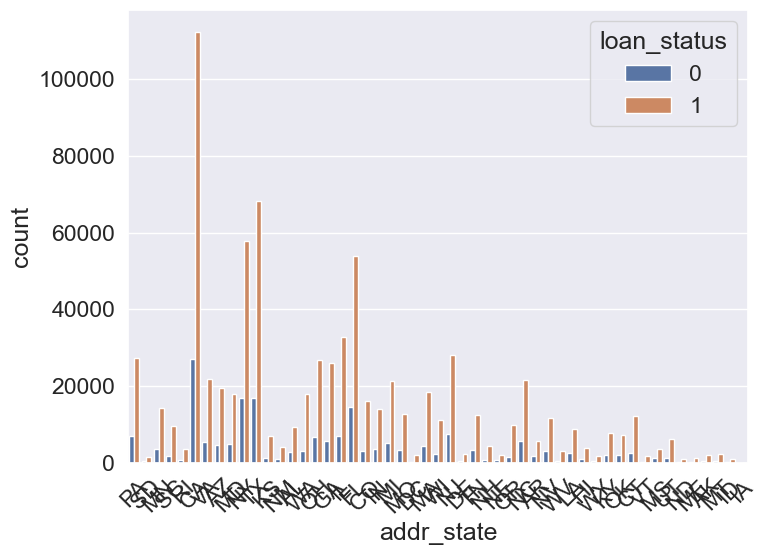

In [29]:
# get a view of the distribution of loans by state
figure(figsize=(8, 6), dpi=100)
sns.countplot(data=df_null_rem, x='addr_state', hue='loan_status')
plt.xticks(rotation=45)

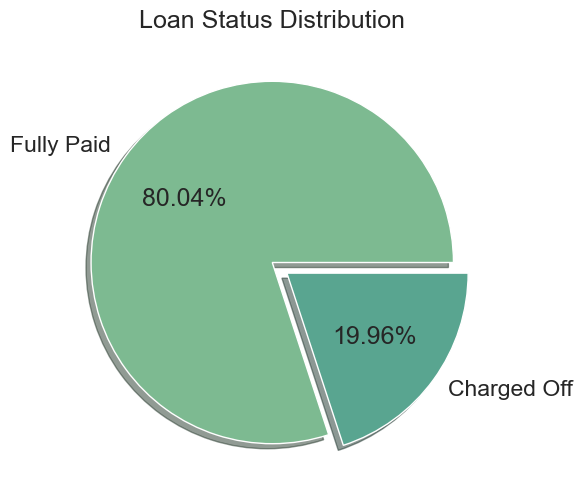

In [30]:
# view the loan status distribution by fully paid/charged off
figure(figsize=(8, 6), dpi=100)
plt.pie(df['loan_status'].value_counts(), 
        labels=['Fully Paid', 'Charged Off'], 
        autopct='%.02f%%', colors=sns.color_palette("crest"), 
        explode=(0, 0.1), shadow=True)
plt.title('Loan Status Distribution')
plt.show()

### Normalizing the Data
Above is the most recent look at the data distribution for loan status. As we've seen with some plots above, the data is difficult to intepret when the sample data sizes are too different. In order to make it easier to interpret loan status comparisons, we normalized the data.

Below, a new dataset was created that evenly sampled from both types of loan statuses.

In [31]:
# put all the charged off records in a separate dataset.
df_charged = df_null_rem.loc[df_null_rem['loan_status'] == 0]

# undersample the fully paid observations, since there are so many more of them
df_paid = df_null_rem.loc[df_null_rem['loan_status'] == 1].sample(n=len(df_charged.index),random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([df_charged, df_paid])

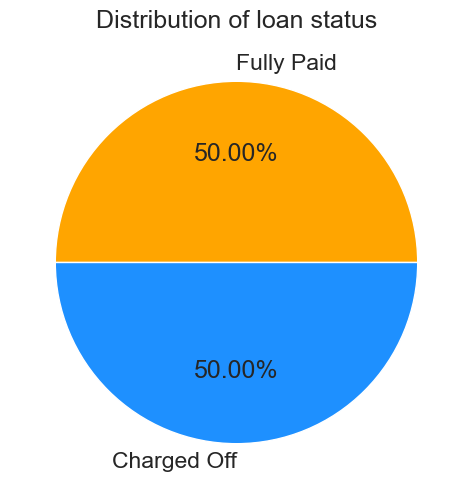

In [32]:
# verify that the distribution of fully paid and charged are even
# this will help to visualize proportions in graphs
figure(figsize=(8, 6), dpi=100)
plt.pie(normalized_df['loan_status'].value_counts(), 
        labels=['Fully Paid', 'Charged Off'], 
        autopct='%.02f%%',
        colors = ["orange", "dodgerblue"])
plt.title('Distribution of loan status')
plt.show()

**Go through the normalized_df dataset and remove everything unnecessary**

In [33]:
# make a copy of the normalized dataset
data = normalized_df.copy()

In [34]:
# list all of the different features
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390776 entries, 7 to 242024
Data columns (total 93 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          390776 non-null  object 
 1   loan_amnt                   390776 non-null  float64
 2   funded_amnt                 390776 non-null  float64
 3   funded_amnt_inv             390776 non-null  float64
 4   term                        390776 non-null  object 
 5   int_rate                    390776 non-null  float64
 6   installment                 390776 non-null  float64
 7   grade                       390776 non-null  object 
 8   sub_grade                   390776 non-null  object 
 9   emp_title                   390776 non-null  object 
 10  emp_length                  390776 non-null  int64  
 11  home_ownership              390776 non-null  object 
 12  annual_inc                  390776 non-null  float64
 13  verification_s

In [35]:
# drop url since it is unnecessary
data['url'].nunique()
data.drop('url', axis=1, inplace=True)

In [36]:
# employment titles are arbitrary, so drop that
data['emp_title'].nunique()
data.drop('emp_title', axis=1, inplace=True)

<AxesSubplot:xlabel='emp_length', ylabel='count'>

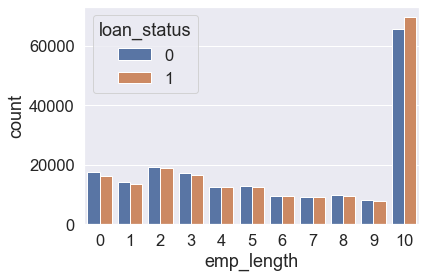

In [37]:
# employment length seems to have a very even distribution among both defaulted and paid
# graph using normalized dataframe to see proportions
sns.countplot(data=data, hue='loan_status', x='emp_length')

In [38]:
# so drop the employment length
data.drop('emp_length', axis=1, inplace=True)

In [39]:
# employment titles are arbitrary
data['title'].nunique()
data.drop('title', axis=1, inplace=True)

In [40]:
# data purpose seems to have a finite number of columns
data.purpose.value_counts()

debt_consolidation    235256
credit_card            80756
home_improvement       24594
other                  21831
major_purchase          8016
small_business          4604
medical                 4399
car                     3421
moving                  2800
vacation                2476
house                   2119
wedding                  254
renewable_energy         250
Name: purpose, dtype: int64

<AxesSubplot:xlabel='mort_acc', ylabel='Count'>

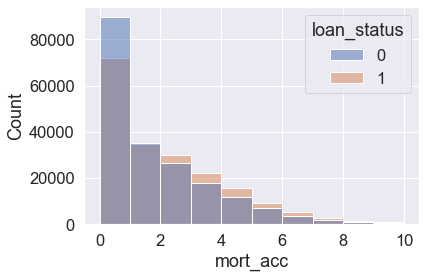

In [41]:
# mort_acc seems to have a difference in distribution, so keep that
sns.histplot(data=data, hue='loan_status', x='mort_acc', binrange=(0,10), bins=10)

In [42]:
# the term could play a role in the distribution of loan status
data['term'].value_counts()

 36 months    267384
 60 months    123392
Name: term, dtype: int64

In [43]:
# replace the strings with integers
data.loc[:, 'term'].replace({' 36 months': 0, ' 60 months': 1}, inplace=True)

In [44]:
data['term'].value_counts()

0    267384
1    123392
Name: term, dtype: int64

In [45]:
# make a copy of the data 
data2 = data.copy()

In [46]:
# sub_grade uses a further specification than grade, so grade will roughly have the same usage with less sparsity
data.drop('sub_grade', axis=1, inplace=True)

In [47]:
# identify which categorical columns remain
print([column for column in data.columns if data[column].dtype == 'object'])

['id', 'grade', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [48]:
print(data['zip_code'].value_counts())
# a lot of categorical variables
data.drop('zip_code', axis=1, inplace=True)

750xx    4424
945xx    4120
331xx    3619
112xx    3608
606xx    3448
300xx    3300
891xx    3298
070xx    3218
770xx    3140
330xx    3123
900xx    2944
117xx    2792
917xx    2791
104xx    2778
852xx    2574
100xx    2412
925xx    2394
921xx    2371
913xx    2278
334xx    2232
926xx    2227
481xx    2168
080xx    2137
853xx    2103
604xx    2090
760xx    2059
601xx    2057
773xx    2003
600xx    1951
956xx    1894
207xx    1892
928xx    1885
774xx    1859
113xx    1829
920xx    1821
301xx    1808
850xx    1762
782xx    1738
923xx    1721
021xx    1706
480xx    1703
980xx    1683
201xx    1670
212xx    1647
333xx    1632
114xx    1596
553xx    1595
902xx    1591
088xx    1560
275xx    1525
775xx    1518
951xx    1513
840xx    1490
605xx    1486
802xx    1481
752xx    1474
786xx    1465
328xx    1461
554xx    1458
953xx    1452
890xx    1449
967xx    1387
327xx    1377
441xx    1376
483xx    1354
958xx    1348
302xx    1346
761xx    1345
800xx    1319
282xx    1309
191xx    1305
190xx 

In [49]:
# the month which the loan was funded - is a data leak
data.drop('issue_d', axis=1, inplace=True)

In [50]:
# earliest credit line, choose not to focus on it
data['earliest_cr_line'].value_counts().head()
data.drop('earliest_cr_line', axis=1, inplace=True)

In [51]:
# id does not contribute to loan status
data.drop('id', axis=1, inplace=True)

In [52]:
print(data['hardship_flag'].value_counts())

N    390776
Name: hardship_flag, dtype: int64


In [53]:
# all of them seem to lack it, so drop
data.drop('hardship_flag', axis=1, inplace=True)

In [54]:
# the payment dates are data leakage, and the verification status was deemed irrelevant
data.drop(['verification_status', 'last_pymnt_d', 'last_credit_pull_d'], axis=1, inplace=True)

In [55]:
print([column for column in data.columns if data[column].dtype == 'object'])

['grade', 'home_ownership', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'disbursement_method', 'debt_settlement_flag']


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'RENT'),
  Text(1, 0, 'MORTGAGE'),
  Text(2, 0, 'OWN'),
  Text(3, 0, 'ANY'),
  Text(4, 0, 'NONE'),
  Text(5, 0, 'OTHER')])

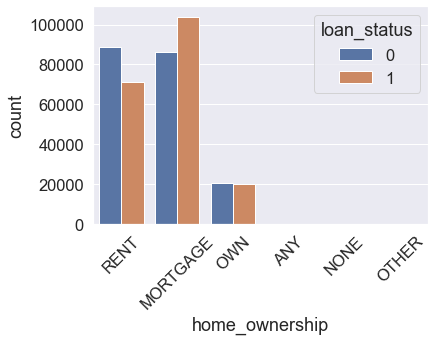

In [56]:
# check home ownership distribution
sns.countplot(data=data, x='home_ownership', hue='loan_status')
plt.xticks(rotation=45)

n    390776
Name: pymnt_plan, dtype: int64


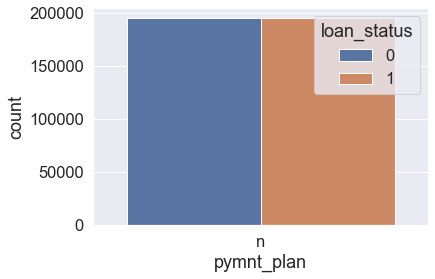

In [57]:
# check payment plan distribution
sns.countplot(data=data, x='pymnt_plan', hue='loan_status')
print(normalized_df['pymnt_plan'].value_counts())

In [58]:
# no one has payment plans (n), so drop that feature
data.drop('pymnt_plan', axis=1, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'debt_consolidation'),
  Text(1, 0, 'small_business'),
  Text(2, 0, 'credit_card'),
  Text(3, 0, 'car'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'major_purchase'),
  Text(6, 0, 'other'),
  Text(7, 0, 'house'),
  Text(8, 0, 'medical'),
  Text(9, 0, 'vacation'),
  Text(10, 0, 'moving'),
  Text(11, 0, 'renewable_energy'),
  Text(12, 0, 'wedding')])

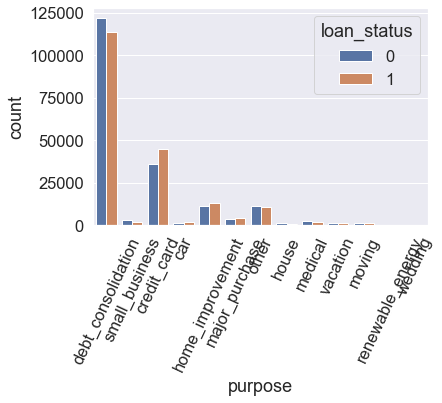

In [59]:
# visualize purpose distribution
sns.countplot(data=data, x='purpose', hue='loan_status')
plt.xticks(rotation=65)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, 'CA'),
  Text(1, 0, 'KS'),
  Text(2, 0, 'AL'),
  Text(3, 0, 'MD'),
  Text(4, 0, 'CO'),
  Text(5, 0, 'VA'),
  Text(6, 0, 'DE'),
  Text(7, 0, 'NY'),
  Text(8, 0, 'MA'),
  Text(9, 0, 'OH'),
  Text(10, 0, 'IL'),
  Text(11, 0, 'NJ'),
  Text(12, 0, 'PA'),
  Text(13, 0, 'NV'),
  Text(14, 0, 'NH'),
  Text(15, 0, 'TX'),
  Text(16, 0, 'TN'),
  Text(17, 0, 'GA'),
  Text(18, 0, 'WA'),
  Text(19, 0, 'FL'),
  Text(20, 0, 'HI'),
  Text(21, 0, 'NC'),
  Text(22, 0, 'MO'),
  Text(23, 0, 'OK'),
  Text(24, 0, 'CT'),
  Text(25, 0, 'AR'),
  Text(26, 0, 'OR'),
  Text(27, 0, 'MS'),
  Text(28, 0, 'SC'),
  Text(29, 0, 'NE'),
  Text(30, 0, 'LA'),
  Text(31, 0, 'AZ'),
  Text(32, 0, 'WV'),
  Text(33, 0, 'IN'),
  Text(34, 0, 'MI'),
  Text(35, 0, 'KY'),
  Text(36, 0, 'UT'),
  Text(

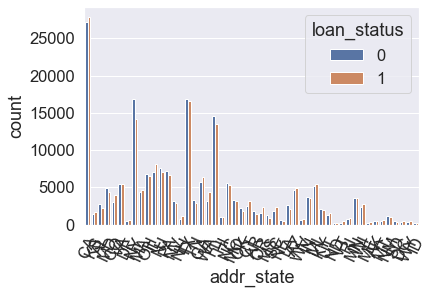

In [60]:
# visualize state distribution
sns.countplot(data=data, x='addr_state', hue='loan_status')
plt.xticks(rotation=65)

w    238238
f    152538
Name: initial_list_status, dtype: int64


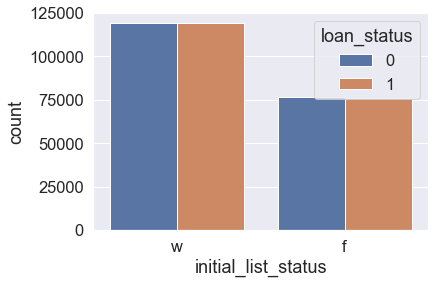

In [61]:
# check values for initial list status
sns.countplot(data=data, x='initial_list_status', hue='loan_status')
print(normalized_df['initial_list_status'].value_counts())

In [62]:
# evenly divided, so drop
data.drop('initial_list_status', axis=1, inplace=True)

(array([0, 1]), [Text(0, 0, 'Individual'), Text(1, 0, 'Joint App')])

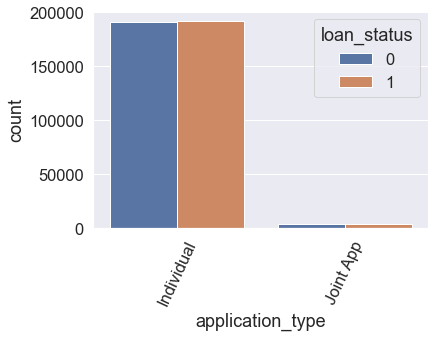

In [63]:
# view application type distribution
sns.countplot(data=data, x='application_type', hue='loan_status')
plt.xticks(rotation=65)

In [64]:
# roughly even distribution, so drop
data.drop('application_type', axis=1, inplace=True)

(array([0, 1]), [Text(0, 0, 'Cash'), Text(1, 0, 'DirectPay')])

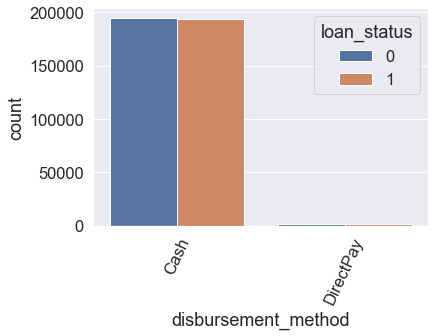

In [65]:
# view disbursement method distribution
sns.countplot(data=data, x='disbursement_method', hue='loan_status')
plt.xticks(rotation=65)

In [66]:
# roughly even distribution, so drop
data.drop('disbursement_method', axis=1, inplace=True)

N    365844
Y     24932
Name: debt_settlement_flag, dtype: int64

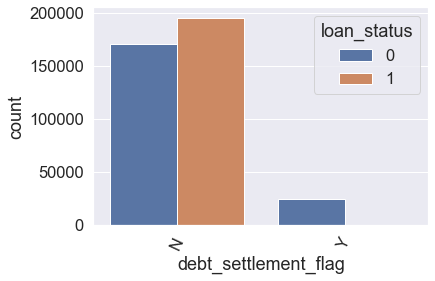

In [67]:
# view debt settlement method distribution
sns.countplot(data=data, x='debt_settlement_flag', hue='loan_status')
plt.xticks(rotation=65)
data['debt_settlement_flag'].value_counts()

In [68]:
# replace the strings with integers
data.loc[:, 'debt_settlement_flag'].replace({'N': 0, 'Y': 1}, inplace=True)
print(data['debt_settlement_flag'].value_counts())

0    365844
1     24932
Name: debt_settlement_flag, dtype: int64


In [69]:
print([column for column in data.columns if data[column].dtype == 'object'])

['grade', 'home_ownership', 'purpose', 'addr_state']


In [70]:
# drop the grade column because it correlates directly with interest_rate
data.drop('grade', axis=1, inplace=True)

# drop the interest rate to not rely solely on Lendingclub's model
data.drop('int_rate', axis=1, inplace=True)

In [71]:
# create two data sets for numeric and non-numeric data
data_num = data.select_dtypes(exclude=['object'])
data_str = data.select_dtypes(include=['object'])

# one-hot encode the non-numeric columns
data_str_onehot = pd.get_dummies(data_str)

# union the one-hot encoded columns to the numeric ones
data = pd.concat([data_num, data_str_onehot], axis=1)

# print the columns in the new data set
print(data.columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment',
       'annual_inc', 'loan_status', 'dti', 'delinq_2yrs', 'fico_range_low',
       ...
       'addr_state_SD', 'addr_state_TN', 'addr_state_TX', 'addr_state_UT',
       'addr_state_VA', 'addr_state_VT', 'addr_state_WA', 'addr_state_WI',
       'addr_state_WV', 'addr_state_WY'],
      dtype='object', length=140)


In [72]:
# view the dataframe's types
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390776 entries, 7 to 242024
Data columns (total 140 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    loan_amnt                   float64
 1    funded_amnt                 float64
 2    funded_amnt_inv             float64
 3    term                        int64  
 4    installment                 float64
 5    annual_inc                  float64
 6    loan_status                 int64  
 7    dti                         float64
 8    delinq_2yrs                 float64
 9    fico_range_low              float64
 10   fico_range_high             float64
 11   inq_last_6mths              float64
 12   open_acc                    float64
 13   pub_rec                     float64
 14   revol_bal                   float64
 15   revol_util                  float64
 16   total_acc                   float64
 17   out_prncp                   float64
 18   out_prncp_inv               float64
 19   

## Model creation and tuning
How can we find a model which takes into account all the data and focuses heavily on limiting the amount of losses and defaults?

In [73]:
# instantiate a show_results function
def show_results(y_test, y_pred):
    # output the accuracy of our prediction
    print(f"Accuracy of Classifier is {round(accuracy_score(y_test, y_pred)*100,2)}%")
    # visualize the confusion matrix to make it easier to read
    con_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid'), ('Charged Off', 'Fully Paid'))
    heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
    plt.ylabel('Actual', fontsize = 14)
    plt.xlabel('Predicted', fontsize = 14)
    # print the classification report
    print(classification_report(y_test, y_pred))

In [74]:
# get a test_train_split of the data df
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['loan_status']), data['loan_status'], test_size=0.3, random_state=42)

Accuracy of Classifier is 96.6%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     58570
           1       0.98      0.96      0.97     58663

    accuracy                           0.97    117233
   macro avg       0.97      0.97      0.97    117233
weighted avg       0.97      0.97      0.97    117233



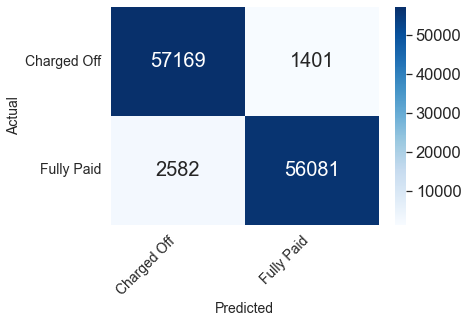

In [75]:
# instantiate a Random Forest Classifier
forest = RandomForestClassifier(max_features=5, n_estimators=35, max_depth=6,random_state=21)

# train the model using the training sets
forest.fit(X_train, y_train)  

# predict the response for test dataset
y_pred = forest.predict(X_test)

# call function to evaluate and show model performance
show_results(y_test, y_pred)

### Why does the model performance seem so high?
There must be data leaks, or features in the data which may be causally affected by the loan status.

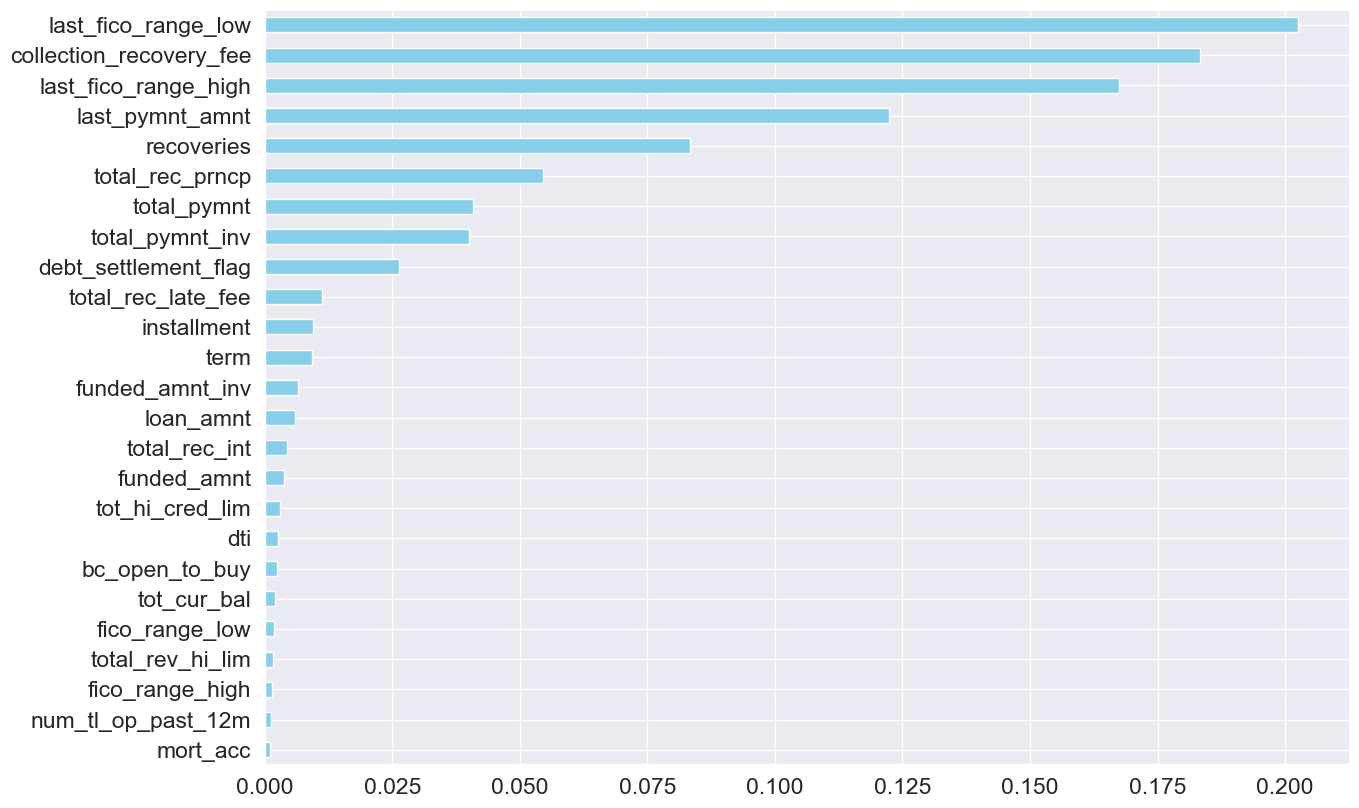

In [76]:
feat_importances = pd.Series(forest.feature_importances_, index=data.drop('loan_status', axis=1).columns)

# sort importances_rf
sorted_importances_rf = feat_importances.sort_values()[-25:]

# make a horizontal bar plot
plt.figure(figsize=(14,10), dpi=100)
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

In [77]:
# remove data leaks
data_leak = ['last_fico_range_low', 
             'last_fico_range_high', 
             'last_pymnt_amnt', 
             'collection_recovery_fee', 
             'total_rec_prncp', 
             'total_pymnt_inv', 
             'total_pymnt',
             'recoveries',
             'total_rec_late_fee',
             'funded_amnt',
             'funded_amnt_inv',
             'total_rec_int',
             'debt_settlement_flag']
data.drop(data_leak, axis=1, inplace=True)

In [78]:
data.shape

(390776, 127)

In [79]:
# have a train test split of the model
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['loan_status']), data['loan_status'], test_size=0.3, random_state=42)

Accuracy of Classifier is 63.4%
              precision    recall  f1-score   support

           0       0.63      0.64      0.64     58570
           1       0.64      0.62      0.63     58663

    accuracy                           0.63    117233
   macro avg       0.63      0.63      0.63    117233
weighted avg       0.63      0.63      0.63    117233



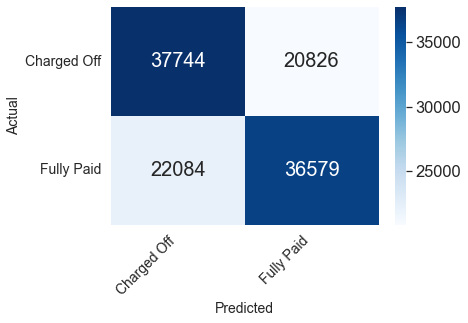

In [80]:
# instantiate a Random Forest Classifier (RandomForestClassifier was previously imported from sklearn)
forest = RandomForestClassifier(max_features=5, n_estimators=35, max_depth=6,random_state=21)

# train the model using the training sets
forest.fit(X_train, y_train)  

# predict the response for test dataset
y_pred = forest.predict(X_test)

# call function to evaluate and show model performance
show_results(y_test, y_pred)

## Strategy
- Keep in mind that from the data and eliminating data leaks, we need to see how best to eliminate any false positives, because that means we lose some portion of the principal because of the charged off status. 
- This means that we will need to increase the probability threshold from the random forest classifier model such that we only classify as Fully Paid what we are very certain are correct. This relies on a high degree of precision, which we can obtain from the classification report

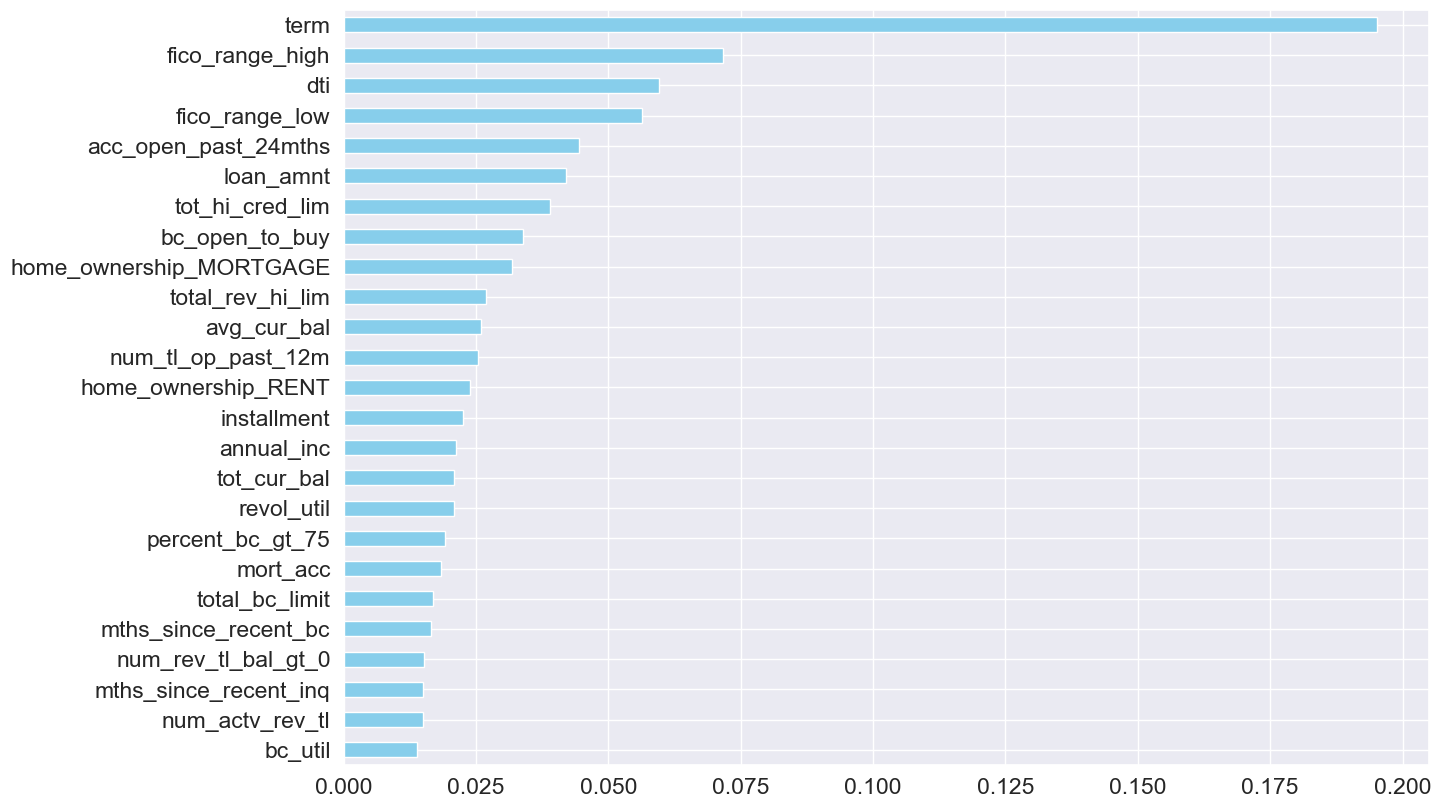

In [81]:
feat_importances = pd.Series(forest.feature_importances_, index=data.drop('loan_status', axis=1).columns)

# sort importances_rf
sorted_importances_rf = feat_importances.sort_values()[-25:]

# make a horizontal bar plot
plt.figure(figsize=(14,10), dpi=100)
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

Accuracy of Classifier is 64.15%
              precision    recall  f1-score   support

           0       0.64      0.63      0.64     58570
           1       0.64      0.65      0.65     58663

    accuracy                           0.64    117233
   macro avg       0.64      0.64      0.64    117233
weighted avg       0.64      0.64      0.64    117233



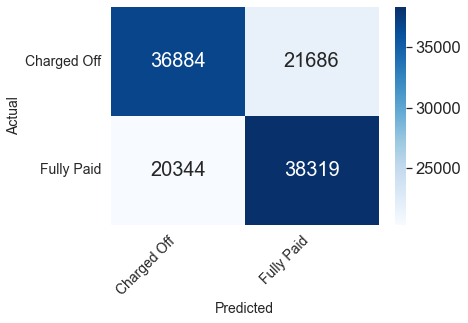

In [82]:
# now we make a separate random forest classifier, one with different parameters, made with the purpose 
# of optimizing the precision of choosing fully paid loans
from sklearn.ensemble import RandomForestRegressor
forest2 = RandomForestClassifier(max_features=15, n_estimators=25, max_depth=8,random_state=21)

# 2. Train the model using the training sets
forest2.fit(X_train, y_train)  

# 3. Predict the response for test dataset
y_pred = forest2.predict(X_test)

# 4. Call function to evaluate and show model performance
show_results(y_test, y_pred)

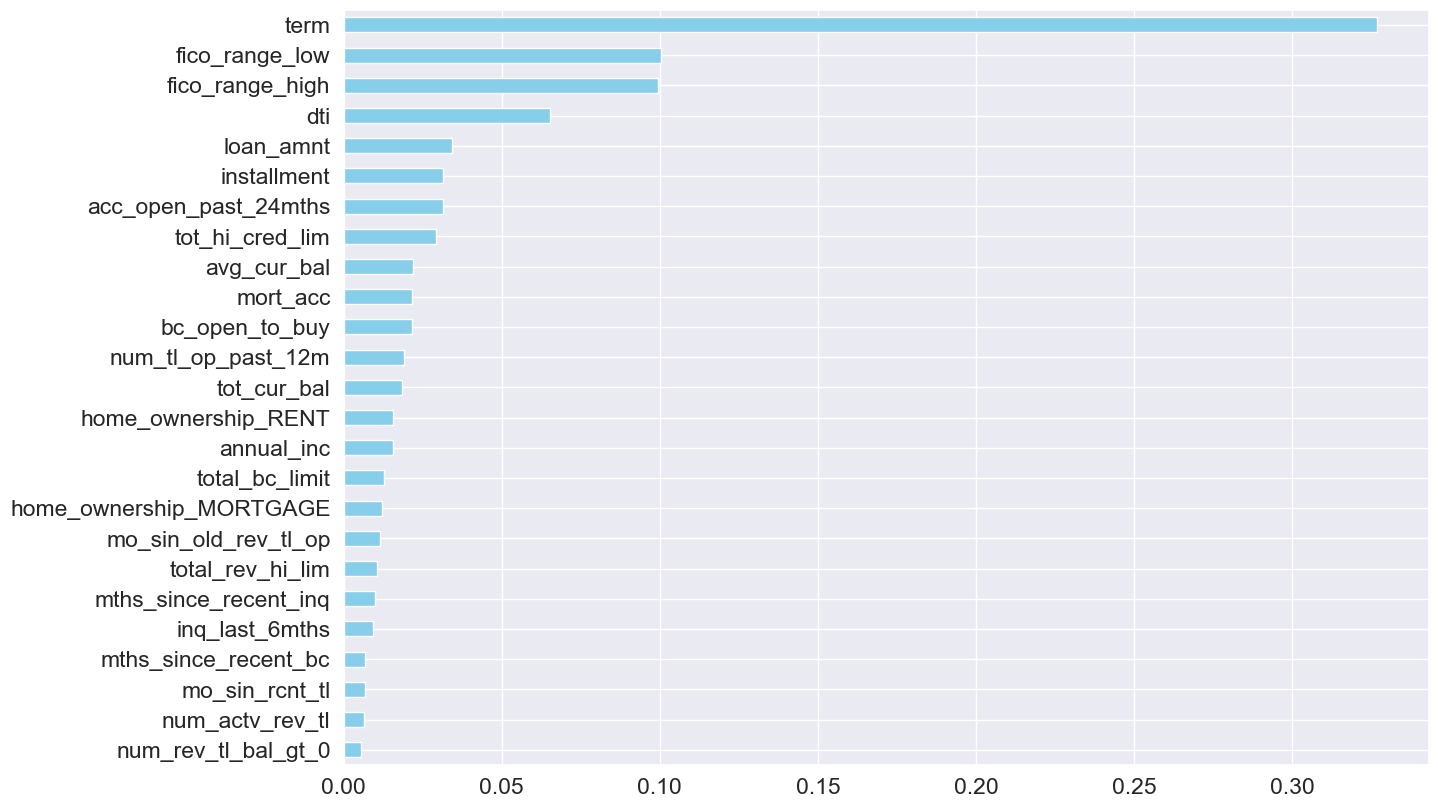

In [83]:
# what are the features that are deemed important in our model?
feat_importances = pd.Series(forest2.feature_importances_, index=data.drop('loan_status', axis=1).columns)

# sort importances_rf
sorted_importances_rf = feat_importances.sort_values()[-25:]

# make a horizontal bar plot
plt.figure(figsize=(14,10), dpi=100)
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

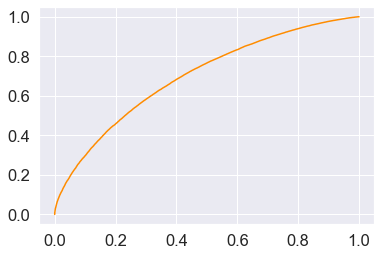

In [84]:
# plot ROC curve
fallout, sensitivity, thresholds = roc_curve(y_test, forest2.predict_proba(X_test)[:, 1])
plt.plot(fallout, sensitivity, color = 'darkorange')

In [85]:
# derive the probabilistic predictions of forest2 on the test set
y_pred_prob = forest2.predict_proba(X_test)
print(y_pred_prob)

[[0.50945216 0.49054784]
 [0.59822039 0.40177961]
 [0.44767422 0.55232578]
 ...
 [0.37857814 0.62142186]
 [0.43378466 0.56621534]
 [0.57124195 0.42875805]]


In [86]:
# convert the numpy array into a dataframe
y_prob_df = pd.DataFrame(y_pred_prob)

In [87]:
# apply a lambda function to ensure that only high-likelihood predictions are predicted to be fully paid
y_prob_df['val'] = y_prob_df[1].apply(lambda x: 1 if x > 0.82 else 0)

Accuracy of Classifier is 50.75%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     58570
           1       0.94      0.02      0.03     58663

    accuracy                           0.51    117233
   macro avg       0.72      0.51      0.35    117233
weighted avg       0.72      0.51      0.35    117233



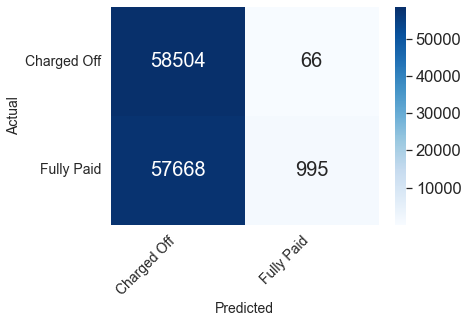

In [88]:
show_results(y_test, y_prob_df['val'])

## Optimize precision
Our rationale is that we need to minimize the number of defaults at any cost, first and foremost. We assume that the principal losses outweigh the interest profits by nature of the interest rates, so what we want to do is make sure our model, if it predicts a fully paid loan, will indeed select a loan that is fully paid off from the features available at the time

In [89]:
# make a dataframe of the high probability predictions
high_prob = X_test.iloc[y_prob_df[y_prob_df['val'] == 1].index]

In [90]:
# the incorrectly classified 'Fully Paid' loans can be ignored for the purposes of plotting
# because of the high precision
high_prob.shape

(1061, 126)

In [91]:
high_prob.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 83799 to 262089
Data columns (total 126 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    loan_amnt                   float64
 1    term                        int64  
 2    installment                 float64
 3    annual_inc                  float64
 4    dti                         float64
 5    delinq_2yrs                 float64
 6    fico_range_low              float64
 7    fico_range_high             float64
 8    inq_last_6mths              float64
 9    open_acc                    float64
 10   pub_rec                     float64
 11   revol_bal                   float64
 12   revol_util                  float64
 13   total_acc                   float64
 14   out_prncp                   float64
 15   out_prncp_inv               float64
 16   collections_12_mths_ex_med  float64
 17   policy_code                 float64
 18   acc_now_delinq              float64
 19 

Text(0.5, 1.0, 'High Probability Fully Paid')

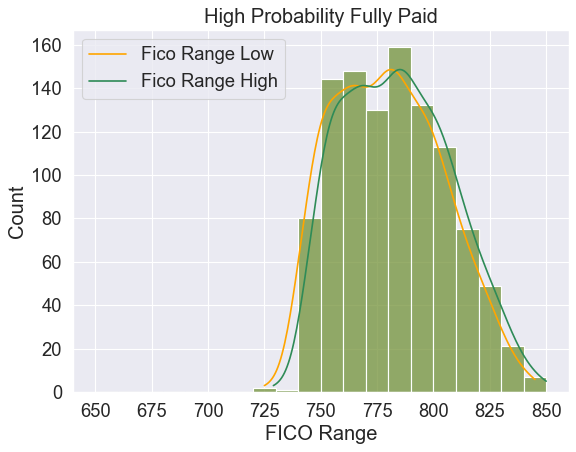

In [92]:
# what is the distribution of the FICO ranges for the high probability set?
color=sns.color_palette('crest')
figure(figsize=(8, 6), dpi=80)
sns.histplot(data=high_prob, x='fico_range_low', bins=20, binrange=[650, 850], color='orange', kde=True)
sns.histplot(data=high_prob, x='fico_range_high', bins=20, binrange=[650, 850], color='seagreen', kde=True)
plt.legend(['Fico Range Low', 'Fico Range High'], loc='upper left')
plt.xlabel('FICO Range')
plt.title('High Probability Fully Paid')


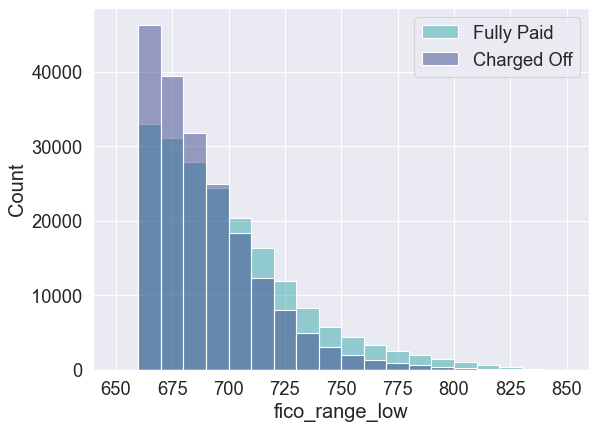

In [93]:
# visualize the FICO Score distribution of the normalized dataframe
figure(figsize=(8, 6), dpi=80)
sns.histplot(data=normalized_df, x='fico_range_low', hue='loan_status', palette='mako', bins=20, binrange=[650, 850])
plt.legend(['Fully Paid', 'Charged Off'])

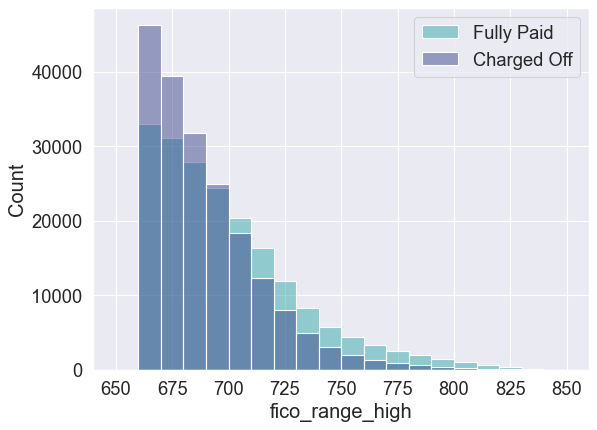

In [94]:
# visualize the FICO Score distribution of the normalized dataframe
figure(figsize=(8, 6), dpi=80)
sns.histplot(data=normalized_df, x='fico_range_high', hue='loan_status', palette='mako', bins=20, binrange=[650, 850])
plt.legend(['Fully Paid', 'Charged Off'])

Text(0.5, 1.0, 'DTI of High Probability Paid Loans')

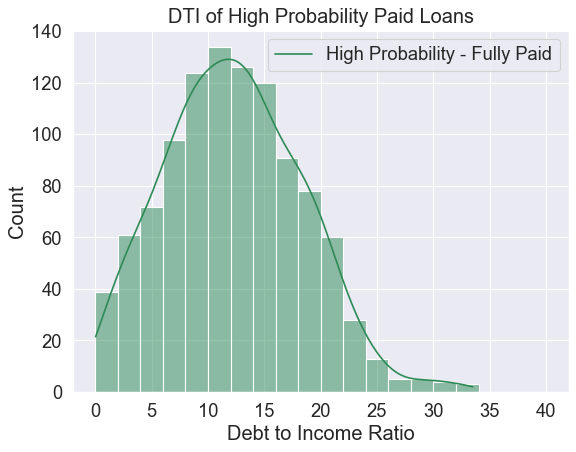

In [95]:
# what is the distribution of the debt to income ratio of the high probability set?
figure(figsize=(8, 6), dpi=80)
sns.histplot(data=high_prob, x='dti', color='seagreen', kde=True, binrange=[0, 40], bins=20)
plt.legend(['High Probability - Fully Paid'], loc='upper right')
plt.xlabel('Debt to Income Ratio')
plt.title('DTI of High Probability Paid Loans')


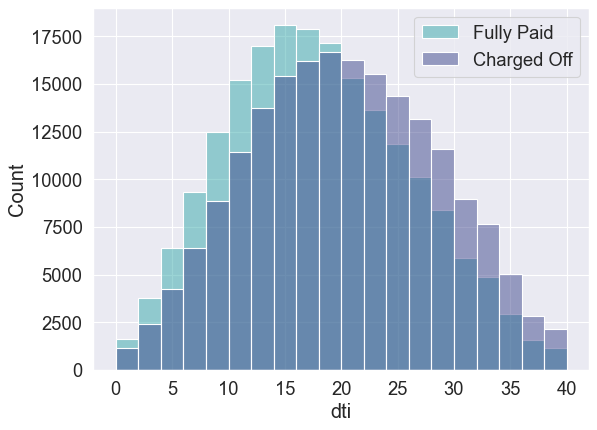

In [96]:
# visualize the DTI distribution of the normalized dataframe
figure(figsize=(8, 6), dpi=80)
sns.histplot(data=normalized_df, x='dti', hue='loan_status', binrange=[0, 40], bins=20, palette='mako')
plt.legend(['Fully Paid', 'Charged Off'])

<AxesSubplot:xlabel='fico_range_low', ylabel='Count'>

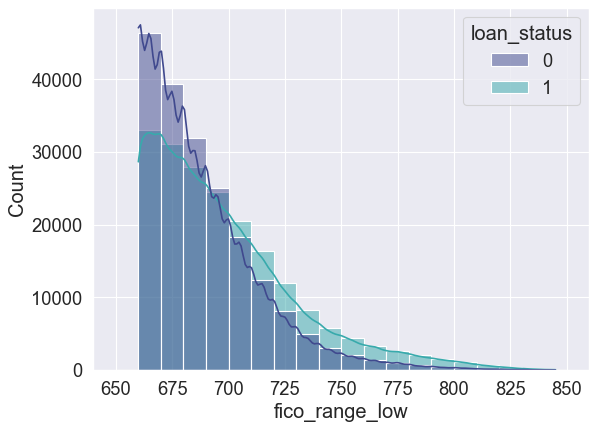

In [97]:
# visualize the fico_range_low of the normalized dataframe
figure(figsize=(8, 6), dpi=80)
sns.histplot(data=normalized_df, x='fico_range_low', hue='loan_status', bins=20, binrange=[650, 850], kde=True, palette='mako')

### Here we explore some average statistics and rationale
- The graphs above give us an idea of how the fico ranges and the debt to income ratios play a role

In [98]:
# what is the median interest rate over all valid samples?
print(df_null_rem['int_rate'].median())

# the median loan amount over all valid samples
print(df_null_rem['loan_amnt'].median())

12.88
12800.0


In [99]:
# FOR FULLY PAID LOANS:
# obtain the median total interest paid
print(df_null_rem[df_null_rem['loan_status'] == 1]['total_rec_int'].median())

# the median loan amount
print(df_null_rem[df_null_rem['loan_status'] == 1]['loan_amnt'].median())

1555.5
12000.0


In [100]:
# FOR CHARGED OFF LOANS:
# the median received interest
print(df_null_rem[df_null_rem['loan_status'] == 0]['total_rec_int'].median())

# the median total payment
med_pay = df_null_rem[df_null_rem['loan_status'] == 0]['total_pymnt'].median()
print(med_pay)

# the median loan amount
med_loan = df_null_rem[df_null_rem['loan_status'] == 0]['loan_amnt'].median()
print(med_loan)

# the median loss per loan
print(med_loan - med_pay)

1938.91
6868.875
15000.0
8131.125


In [101]:
df_sub_grade = df_null_rem.groupby(['sub_grade']).mean()['loan_status']**(df_null_rem.groupby(['sub_grade']).mean()['loan_amnt'] / df_null_rem.groupby(['sub_grade']).mean()['total_rec_int'])

<BarContainer object of 10 artists>

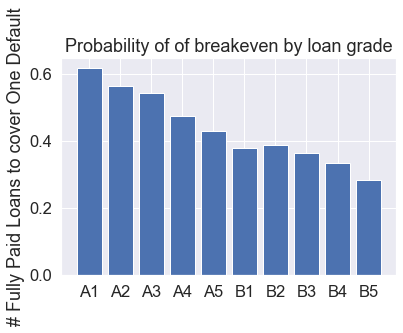

In [102]:
# get the number of fully paid loans needed to cover one default, by loan grade
# the exponent and the rankings query searches through the available data and uses means, grouping by subgrade
# and getting the number of loans to recover the loss of a default
arr = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5']
rankings = df_null_rem.groupby(['sub_grade']).mean()['loan_status']**(df_null_rem.groupby(['sub_grade']).mean()['loan_amnt'] / df_null_rem.groupby(['sub_grade']).mean()['total_rec_int'])
plt.ylabel("# Fully Paid Loans to cover One Default")
plt.title("Probability of of breakeven by loan grade")
plt.bar(arr, rankings[0:10])

Text(0.5, 1.0, 'Term of High Probability Paid Loans')

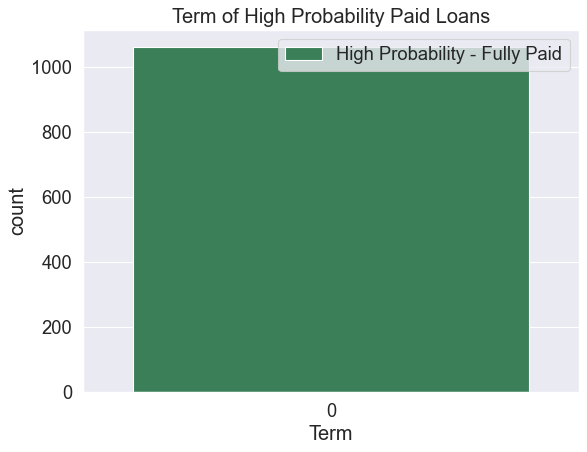

In [103]:
# what is the distribution of the term of the high probability set?
figure(figsize=(8, 6), dpi=80)
sns.countplot(data=high_prob, x='term', color='seagreen')
plt.legend(['High Probability - Fully Paid'], loc='upper right')
plt.xlabel('Term')
plt.title('Term of High Probability Paid Loans')
# it turns out that they are all the 0 term, or 36 months


In [104]:
normalized_df.loc[:, 'term'].replace({' 36 months': 36, ' 60 months': 60}, inplace=True)
normalized_df['term'].value_counts()

36    267384
60    123392
Name: term, dtype: int64

Text(0.5, 1.0, '36 Month Term')

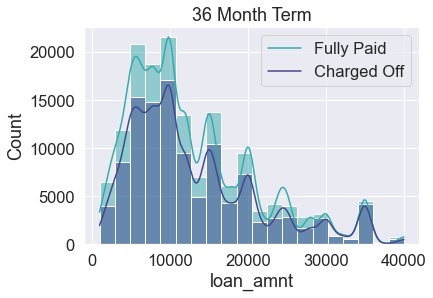

In [105]:
# what is the distribution of the term of the high probability set?
# figure(figsize=(8, 6), dpi=80)
sns.histplot(data=normalized_df[normalized_df['term'] == 36], x='loan_amnt', palette='mako', hue='loan_status', bins=20, kde=True)
plt.legend(['Fully Paid', 'Charged Off'])
plt.title('36 Month Term')


Text(0.5, 1.0, '60 Month Term')

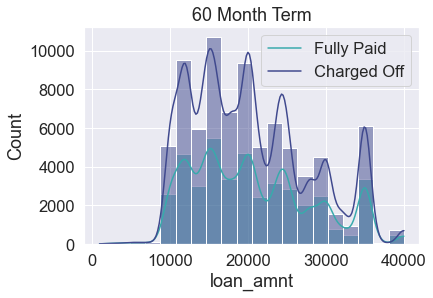

In [106]:
sns.histplot(data=normalized_df[normalized_df['term'] == 60], x='loan_amnt', palette='mako', hue='loan_status', bins=20, kde=True)
plt.legend(['Fully Paid', 'Charged Off'])
plt.title('60 Month Term')

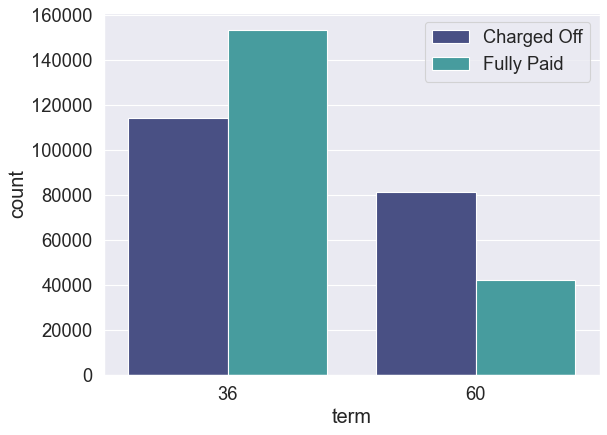

In [107]:
# what is the distribution of the term of the high probability set?
figure(figsize=(8, 6), dpi=80)
sns.countplot(data=normalized_df, x='term', palette='mako', hue='loan_status')
plt.legend(['Charged Off', 'Fully Paid'])

<BarContainer object of 10 artists>

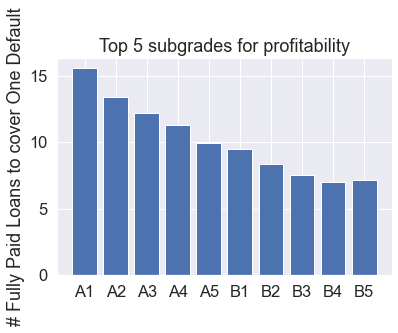

In [108]:
# plot the number of fully paid loans required to break even with one default
arr = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5']
rankings = (df_null_rem.groupby(['sub_grade']).mean()['loan_amnt'] / df_null_rem.groupby(['sub_grade']).mean()['total_rec_int'])
plt.ylabel("# Fully Paid Loans to cover One Default")
plt.title("Top 5 subgrades for profitability")
plt.bar(arr, rankings[0:10])

Text(0.5, 1.0, 'Profitability of Each Loan Purpose')

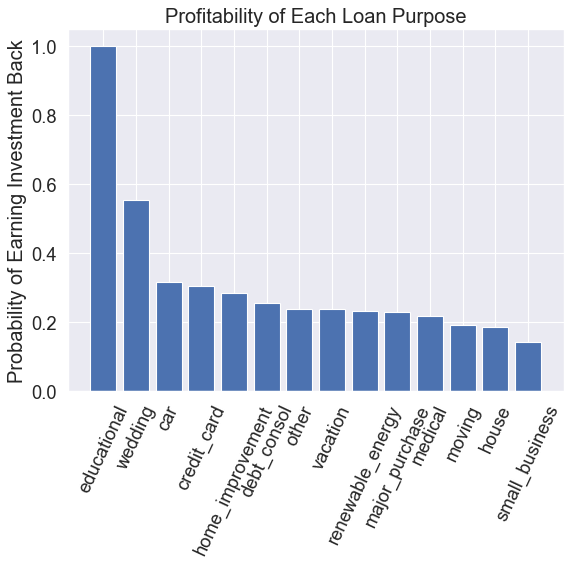

In [109]:
# probability of earning the investment back, based on purpose
rankings = df_null_rem.groupby(['purpose']).mean()['loan_status']**(df_null_rem.groupby(['purpose']).mean()['loan_amnt'] / df_null_rem.groupby(['purpose']).mean()['total_rec_int'])
rankings = rankings.sort_values(ascending = False)
purposes = ['educational', 'wedding', 'car', 'credit_card', 'home_improvement', 'debt_consol', 'other', 'vacation', 'renewable_energy', 'major_purchase', 'medical', 'moving', 'house', 'small_business']
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=65)
plt.bar(purposes, rankings)
plt.ylabel('Probability of Earning Investment Back')
plt.title('Profitability of Each Loan Purpose')

## Conclusion
Ultimately, our analysis focuses heavily on an exploration of the features and understanding the correlation between certain model features to identify fully paid loans. We reduce our focus on the charged off loans because we want to only invest in the loans that are strongly correlated to not defaulting, while making sure no data is leaked. We also minimize our use of the interest rate and loan grades to ensure our competitive advantage while naturally maintaining some correlation with the (sub)grade.